In [1]:
from __future__ import (absolute_import, print_function, division)
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd
import os
import numpy as np
from scipy.stats import norm
import scipy
from scipy.stats import multivariate_normal as mvn
from numpy.linalg import inv
from numpy import log as ln
from numpy.random import random as rand
%matplotlib inline

**Some useful definitions that describes my usage below**

numpy.random.random

numpy.random.random(size=None)
Return random floats in the half-open interval [0.0, 1.0).

Results are from the “continuous uniform” distribution over the stated interval. To sample Unif[a, b), b > a multiply the output of random_sample by (b-a) and add a:

(b - a) * random_sample() + a
Parameters:	
size : int or tuple of ints, optional
Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. Default is None, in which case a single value is returned.
Returns:	
out : float or ndarray of floats
Array of random floats of shape size (unless size=None, in which case a single float is returned).
Examples

>>>
>>> np.random.random_sample()
0.47108547995356098
>>> type(np.random.random_sample())
<type 'float'>
>>> np.random.random_sample((5,))
array([ 0.30220482,  0.86820401,  0.1654503 ,  0.11659149,  0.54323428])
Three-by-two array of random numbers from [-5, 0):

>>>
>>> 5 * np.random.random_sample((3, 2)) - 5
array([[-3.99149989, -0.52338984],
       [-2.99091858, -0.79479508],
       [-1.23204345, -1.75224494]])
scipy.stats.multivariate_normal

scipy.stats.multivariate_normal = <scipy.stats._multivariate.multivariate_normal_gen object at 0x2b45d3298990>[source]
A multivariate normal random variable.

The mean keyword specifies the mean. The cov keyword specifies the covariance matrix.

New in version 0.14.0.

Parameters:	
x : array_like
Quantiles, with the last axis of x denoting the components.
mean : array_like, optional
Mean of the distribution (default zero)
cov : array_like, optional
Covariance matrix of the distribution (default one)
Alternatively, the object may be called (as a function) to fix the mean
and covariance parameters, returning a “frozen” multivariate normal
random variable:
rv = multivariate_normal(mean=None, scale=1)
Frozen object with the same methods but holding the given mean and covariance fixed.
Notes

Setting the parameter mean to None is equivalent to having mean be the zero-vector. The parameter cov can be a scalar, in which case the covariance matrix is the identity times that value, a vector of diagonal entries for the covariance matrix, or a two-dimensional array_like.

The covariance matrix cov must be a (symmetric) positive semi-definite matrix. The determinant and inverse of cov are computed as the pseudo-determinant and pseudo-inverse, respectively, so that cov does not need to have full rank.

The probability density function for multivariate_normal is

$f(x) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}} \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$ ,

where \mu is the mean, \Sigma the covariance matrix, and k is the dimension of the space where x takes values.

Methods

**pdf(x, mean=None, cov=1)**	Probability density function.
logpdf(x, mean=None, cov=1)	Log of the probability density function.
rvs(mean=None, cov=1)	Draw random samples from a multivariate normal distribution.
entropy()	Compute the differential entropy of the multivariate normal.

# Expectatiton Maximization Steps for EMM-GMM

Expectation Step:
------
* Set q(c)(hence the phi_i described below)
* Calculate discrete sum of $ \sum_{c}(q(c)lnp(x,c| \pi, \mu, \Lambda))$

Maximization Step:
------
* Maximize over #2 over $ \pi, \mu, \Lambda$
* Calculate $f_t = \ln p(x | \pi^{t}, \mu^{t}, \Lambda^{t})$

Notes:
-------
* $ q(c_i=j) = \phi_i(j),  \phi_i = \pi_j Normal(x_i | \mu_j, (\Lambda_j^{-1})$
* _i_ range is (1, k)
* $n_j^{(t)} = \sum_{i} \phi_i^{(t)}$
* $\mu_j^{(t)} = 1/n_j^{(t)} \sum_{i} \phi_i^{(t)} x_i$
* $\Lambda_j^{(t)} = (1/n_j^{(t)} \sum_{i} \phi_i^{(t)} (x_i - \mu_j^{t})(x_i - \mu_j^{t})^{T})^{-1}$
* $\pi_j^{t} = n_j^{t} / n$

In [2]:
def EM_GMM(x_train,k,T):
    n, d = x_train.shape
    # phi_i as in phi_i(j) in the lecture notes
    phi_i = rand((n,k))      
    # pi as in discrete distro pi in lecture notes
    pi_j = np.ones(k)
    mu_j = asarray([rand(d) for i in xrange(k)])
    lambda_j = asarray([np.diag(rand(d)) for i in xrange(k)])
    likelihood_list = list()
    mvpdf = mvn.pdf
    for t in range(T): # for each T
        # Expectation Step
        for j in range(k):
            for i, xi in enumerate(x_train.values):
                phi_i[i,j] = pi_j[j] * mvn.pdf(xi, mu_j[j], inv(lambda_j[j])) 
                
        phi_i = phi_i / np.sum(phi_i,axis=1).reshape((n,1)) 
        # Maximization Step
        
        # n_j from notes above, neat since vectorized
        n_j = np.sum(phi_i,axis=0)
        
        # mu_j from notes above
        for j in range(k):
            mu_j[j] = (1.0/n_j[j]) * np.sum(phi_i[:,j].reshape((n,1)) * x_train.values ,axis=0)
        
        #Lambda_j from notes above
        for j in range(k):
            phi_lambda_term = np.zeros((d,d))    
            for i, xi in enumerate(x_train.values):
                x_u = (xi- mu_j[j]).reshape((d,1))
                phi_lambda_term += phi_i[i][j] * x_u.dot(x_u.T)
            lambda_j[j]= inv( (1/n_j[j]) *phi_lambda_term )
        
        # phi_j from notes above
        pi_j = n_j / np.sum(n_j)
        
        
        # And finally, calculate f_t, log likelihood 
        lnp=0
        for i, xi in enumerate(x_train.values):
            px=0
            for j in range(k):
                px+=pi_j[j]*mvpdf(xi, mean=mu_j[j], cov=inv(lambda_j[j]))
            lnp+=ln(px)        
        likelihood_list.append(lnp)
    return phi_i, mu_j, pi_j, lambda_j, n_j, likelihood_list

In [3]:
def likelihood_plot_b(data,k):
    # Part b. Likelihood plot
    fig = plt.figure()
    plt.title('Likelihood Convergence Plot EM-GMM K='+k[5:])
    plt.plot(data[k][5])
    plt.grid()
    
def cluster_plot_c(x_train, data, k):
    # Part c. Cluster plot
    fig2 = plt.figure()
    cluster = [i.argmax() for i in data[k][0]]
    plt.scatter(x_train[0].values,x_train[1].values,c=cluster,s=40)
    plt.title('Cluster Plot EM-GMM K='+k[5:])
    plt.grid()

# Part a. Run EM-GMM for 100 iterations for K = 2, 4, 8, 10

In [7]:
if __name__ == '__main__':
    
    os.chdir('/Users/arkilic/Desktop/')
    xtrn =pd.read_csv('data.txt', header=None)
    emgmms= Or
    emgmms["emgmm2" ]= EM_GMM(xtrn, 2, 100)
    emgmms["emgmm4" ]= EM_GMM(xtrn, 4, 100)
    emgmms["emgmm8" ]= EM_GMM(xtrn, 8, 100)
    emgmms["emgmm10" ]= EM_GMM(xtrn, 10, 100)


# Part b and c. Plot likelihood and Cluster Behavior

**b**. As seen on the plots below, the maximum likelihood term that is used in order to get to the correct marginal distribution converges faster with increasing K. So the number of Gaussians seems to be directly related to the convergence behavior. However, As seen in figure 1 (K=2, likelihood convergence plot), there is a brief section where the likelihood graph seems to be converging, yet there is an obvious jump prior to the actual convergence point. Therefore, choice of K seems quite ambgious. This falls along the same line as the discussion in the lecture that suggested the appropriate value of K is not apparent from prior knwledge of the properties of the data set. The below representation in part b is called the "elbow method" in the textbook and it is what I have been referring as "convergence point". Another reason why this might not be the best way to do model selection is the fact that it is purely experimental since we run the models with various K and suggest that K is the optimal one when increasing K does not make a big difference. Running the model below takes a very long time for even small K. For large K, this sort of experimental approach would take a very long time. We could resort to Calinsky criterion etc for more efficient determination of K.

**c**. As we can clearly see below, with increasing K, the clusters that are color coded become more distinct and much more clear. For instance in the plot where K=2, there are essentially 2 clusters/groups that a data's attributes belongs to. However, in case of K=4 there are 3 distinct clusters and in case of K>=8 there are 6. As likelihood is the measure of closeness for a singular data point to a group

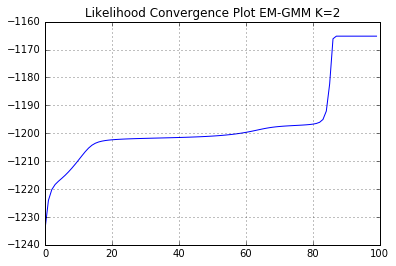

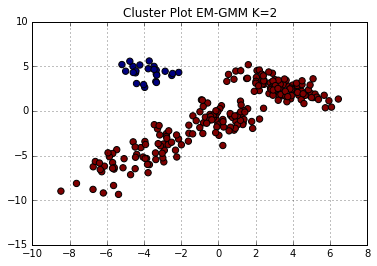

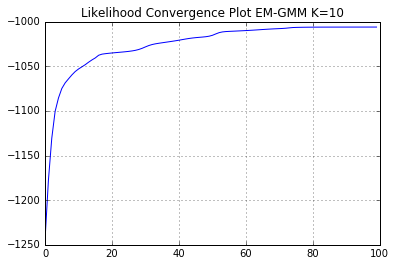

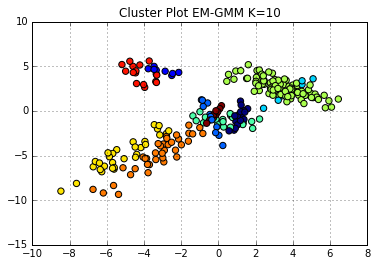

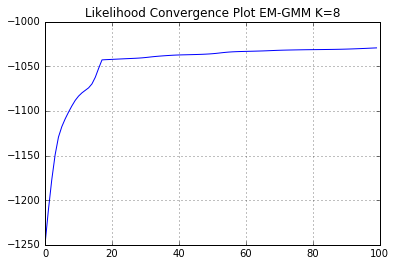

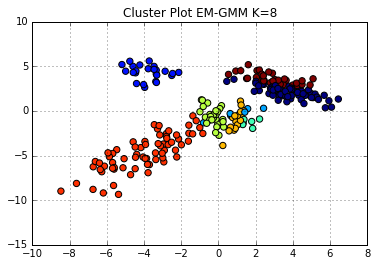

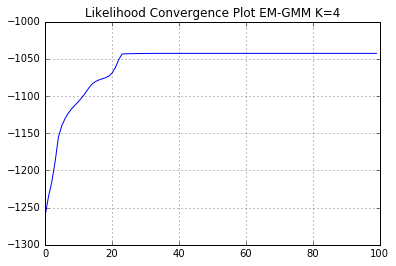

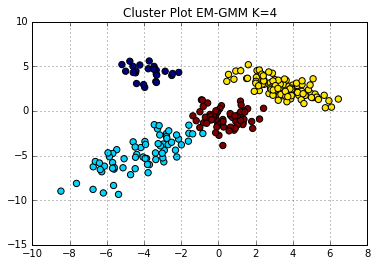

In [9]:
    for egm in emgmms:
        likelihood_plot_b(emgmms,egm)
        cluster_plot_c(xtrn, emgmms, egm)